# Deep $Q$-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use $Q$-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://github.com/openai/gym). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import numpy as np

# Create the Cart-Pole game environment
env = gym.make('CartPole-v1')

# Number of possible actions
print('Number of possible actions:', env.action_space.n)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Number of possible actions: 2


We interact with the simulation through `env`.  You can see how many actions are possible from `env.action_space.n`, and to get a random action you can use `env.action_space.sample()`.  Passing in an action as an integer to `env.step` will generate the next step in the simulation.  This is general to all Gym games. 

In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to interact with the environment.

In [2]:
actions = [] # actions that the agent selects
rewards = [] # obtained rewards
state = env.reset()

while True:
    action = env.action_space.sample()  # choose a random action
    state, reward, done, _ = env.step(action) 
    rewards.append(reward)
    actions.append(action)
    if done:
        break

We can look at the actions and rewards:

In [3]:
print('Actions:', actions)
print('Rewards:', rewards)

Actions: [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0]
Rewards: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


The game resets after the pole has fallen past a certain angle. For each step while the game is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## $Q$-Network

To keep track of the action values, we'll use a neural network that accepts a state $s$ as input.  The output will be $Q$-values for each available action $a$ (i.e., the output is **all** action values $Q(s,a)$ _corresponding to the input state $s$_).

<img src="assets/q-network.png" width=550px>

For this Cart-Pole game, the state has four values: the position and velocity of the cart, and the position and velocity of the pole.  Thus, the neural network has **four inputs**, one for each value in the state, and **two outputs**, one for each possible action. 

As explored in the lesson, to get the training target, we'll first use the context provided by the state $s$ to choose an action $a$, then simulate the game using that action. This will get us the next state, $s'$, and the reward $r$. With that, we can calculate $\hat{Q}(s,a) = r + \gamma \max_{a'}{Q(s', a')}$.  Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

Below is one implementation of the $Q$-network. It uses two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [4]:
import tensorflow as tf

class QNetwork:
    def __init__(self, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, 
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, 
                                                            activation_fn=None)
            
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maximum capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [5]:
from collections import deque

class Memory():
    def __init__(self, max_size=1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## $Q$-Learning training algorithm

We will use the below algorithm to train the network.  For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode $\leftarrow 1$ **to** $M$ **do**
  * Observe $s_0$
  * **For** $t \leftarrow 0$ **to** $T-1$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s_t,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

You are welcome (and encouraged!) to take the time to extend this code to implement some of the improvements that we discussed in the lesson, to include fixed $Q$ targets, double DQNs, prioritized replay, and/or dueling networks.

## Hyperparameters

One of the more difficult aspects of reinforcement learning is the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [8]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [9]:
tf.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)

## Populate the experience memory

Here we re-initialize the simulation and pre-populate the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [10]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent.

In [14]:
import time
import sys

In [16]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    current_time = time.time()
    for ep in range(1, train_episodes):
        
        gap = time.time()-current_time
        print('time-span:', gap)
        sys.stdout.flush()
        current_time = time.time()
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                rewards_list.append((ep, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
        
    saver.save(sess, "checkpoints/cartpole.ckpt")

time-span: 4.0531158447265625e-06
Episode: 1 Total reward: 36.0 Training loss: 1.0208 Explore P: 0.9964
time-span: 0.05276322364807129
Episode: 2 Total reward: 23.0 Training loss: 1.0657 Explore P: 0.9942
time-span: 0.027137041091918945
Episode: 3 Total reward: 39.0 Training loss: 1.0503 Explore P: 0.9903
time-span: 0.04401898384094238
Episode: 4 Total reward: 31.0 Training loss: 1.0529 Explore P: 0.9873
time-span: 0.0350489616394043
Episode: 5 Total reward: 19.0 Training loss: 0.9902 Explore P: 0.9855
time-span: 0.023332834243774414
Episode: 6 Total reward: 27.0 Training loss: 1.0082 Explore P: 0.9828
time-span: 0.031148910522460938
Episode: 7 Total reward: 21.0 Training loss: 0.9760 Explore P: 0.9808
time-span: 0.04099392890930176
Episode: 8 Total reward: 18.0 Training loss: 1.0237 Explore P: 0.9790
time-span: 0.025223255157470703
Episode: 9 Total reward: 10.0 Training loss: 1.0004 Explore P: 0.9781
time-span: 0.01247406005859375
Episode: 10 Total reward: 19.0 Training loss: 1.1140 E

Episode: 81 Total reward: 19.0 Training loss: 78.3263 Explore P: 0.8392
time-span: 0.02704620361328125
Episode: 82 Total reward: 29.0 Training loss: 59.4320 Explore P: 0.8368
time-span: 0.03874373435974121
Episode: 83 Total reward: 22.0 Training loss: 93.7848 Explore P: 0.8349
time-span: 0.029856204986572266
Episode: 84 Total reward: 38.0 Training loss: 62.1833 Explore P: 0.8318
time-span: 0.04926109313964844
Episode: 85 Total reward: 17.0 Training loss: 4531.6050 Explore P: 0.8304
time-span: 0.025588035583496094
Episode: 86 Total reward: 12.0 Training loss: 91.5776 Explore P: 0.8294
time-span: 0.016691923141479492
Episode: 87 Total reward: 11.0 Training loss: 5445.9404 Explore P: 0.8285
time-span: 0.015750885009765625
Episode: 88 Total reward: 16.0 Training loss: 88.7596 Explore P: 0.8272
time-span: 0.021895885467529297
Episode: 89 Total reward: 13.0 Training loss: 104.5136 Explore P: 0.8262
time-span: 0.017269134521484375
Episode: 90 Total reward: 14.0 Training loss: 78.7672 Explore 

time-span: 0.0230710506439209
Episode: 159 Total reward: 14.0 Training loss: 2250.0247 Explore P: 0.7238
time-span: 0.019603967666625977
Episode: 160 Total reward: 12.0 Training loss: 9608.3154 Explore P: 0.7229
time-span: 0.01712512969970703
Episode: 161 Total reward: 9.0 Training loss: 167.4465 Explore P: 0.7223
time-span: 0.012480974197387695
Episode: 162 Total reward: 9.0 Training loss: 305.6556 Explore P: 0.7217
time-span: 0.012771129608154297
Episode: 163 Total reward: 32.0 Training loss: 9761.9199 Explore P: 0.7194
time-span: 0.0412600040435791
Episode: 164 Total reward: 22.0 Training loss: 246.6840 Explore P: 0.7178
time-span: 0.028491973876953125
Episode: 165 Total reward: 22.0 Training loss: 157.7883 Explore P: 0.7163
time-span: 0.02852487564086914
Episode: 166 Total reward: 13.0 Training loss: 150.6888 Explore P: 0.7154
time-span: 0.01739978790283203
Episode: 167 Total reward: 21.0 Training loss: 202.2336 Explore P: 0.7139
time-span: 0.028599977493286133
Episode: 168 Total r

Episode: 237 Total reward: 12.0 Training loss: 1980.1624 Explore P: 0.6280
time-span: 0.01927804946899414
Episode: 238 Total reward: 9.0 Training loss: 3125.2158 Explore P: 0.6275
time-span: 0.01388096809387207
Episode: 239 Total reward: 11.0 Training loss: 31.1820 Explore P: 0.6268
time-span: 0.016163110733032227
Episode: 240 Total reward: 15.0 Training loss: 84.3796 Explore P: 0.6259
time-span: 0.021770000457763672
Episode: 241 Total reward: 27.0 Training loss: 49.7419 Explore P: 0.6242
time-span: 0.03895401954650879
Episode: 242 Total reward: 8.0 Training loss: 42309.6055 Explore P: 0.6237
time-span: 0.01300501823425293
Episode: 243 Total reward: 9.0 Training loss: 31.3371 Explore P: 0.6231
time-span: 0.014523744583129883
Episode: 244 Total reward: 21.0 Training loss: 4780.2588 Explore P: 0.6219
time-span: 0.029204130172729492
Episode: 245 Total reward: 11.0 Training loss: 44.4110 Explore P: 0.6212
time-span: 0.01647806167602539
Episode: 246 Total reward: 33.0 Training loss: 4524.90

Episode: 315 Total reward: 11.0 Training loss: 23.5332 Explore P: 0.5604
time-span: 0.017630338668823242
Episode: 316 Total reward: 7.0 Training loss: 1073.4982 Explore P: 0.5600
time-span: 0.010973930358886719
Episode: 317 Total reward: 8.0 Training loss: 30.9354 Explore P: 0.5596
time-span: 0.013987064361572266
Episode: 318 Total reward: 8.0 Training loss: 12.1353 Explore P: 0.5592
time-span: 0.011757850646972656
Episode: 319 Total reward: 22.0 Training loss: 3609.4949 Explore P: 0.5580
time-span: 0.03208208084106445
Episode: 320 Total reward: 8.0 Training loss: 1545.8680 Explore P: 0.5575
time-span: 0.013796806335449219
Episode: 321 Total reward: 12.0 Training loss: 1004.7213 Explore P: 0.5569
time-span: 0.01887798309326172
Episode: 322 Total reward: 10.0 Training loss: 3744.3977 Explore P: 0.5563
time-span: 0.016108036041259766
Episode: 323 Total reward: 49.0 Training loss: 25.4765 Explore P: 0.5536
time-span: 0.07602214813232422
Episode: 324 Total reward: 9.0 Training loss: 673.60

Episode: 393 Total reward: 15.0 Training loss: 38.2616 Explore P: 0.5052
time-span: 0.021663904190063477
Episode: 394 Total reward: 9.0 Training loss: 33.0694 Explore P: 0.5047
time-span: 0.014092683792114258
Episode: 395 Total reward: 18.0 Training loss: 757.8843 Explore P: 0.5038
time-span: 0.024791955947875977
Episode: 396 Total reward: 14.0 Training loss: 692.1422 Explore P: 0.5031
time-span: 0.021767139434814453
Episode: 397 Total reward: 11.0 Training loss: 7228.1938 Explore P: 0.5026
time-span: 0.016079187393188477
Episode: 398 Total reward: 10.0 Training loss: 2339.6479 Explore P: 0.5021
time-span: 0.015098094940185547
Episode: 399 Total reward: 19.0 Training loss: 22.4881 Explore P: 0.5012
time-span: 0.02803802490234375
Episode: 400 Total reward: 13.0 Training loss: 2714.8975 Explore P: 0.5005
time-span: 0.018639087677001953
Episode: 401 Total reward: 14.0 Training loss: 16.7300 Explore P: 0.4999
time-span: 0.022797822952270508
Episode: 402 Total reward: 9.0 Training loss: 13.

Episode: 471 Total reward: 11.0 Training loss: 454.9022 Explore P: 0.4516
time-span: 0.01680612564086914
Episode: 472 Total reward: 18.0 Training loss: 7.1390 Explore P: 0.4509
time-span: 0.02561783790588379
Episode: 473 Total reward: 17.0 Training loss: 9.9338 Explore P: 0.4501
time-span: 0.023601293563842773
Episode: 474 Total reward: 11.0 Training loss: 1576.9011 Explore P: 0.4496
time-span: 0.01777195930480957
Episode: 475 Total reward: 9.0 Training loss: 250.2423 Explore P: 0.4492
time-span: 0.013659954071044922
Episode: 476 Total reward: 12.0 Training loss: 1072.7521 Explore P: 0.4487
time-span: 0.017117977142333984
Episode: 477 Total reward: 9.0 Training loss: 8.9332 Explore P: 0.4483
time-span: 0.014033317565917969
Episode: 478 Total reward: 8.0 Training loss: 7.9612 Explore P: 0.4480
time-span: 0.011989116668701172
Episode: 479 Total reward: 10.0 Training loss: 8.0344 Explore P: 0.4475
time-span: 0.01515817642211914
Episode: 480 Total reward: 31.0 Training loss: 322.7370 Explo

Episode: 549 Total reward: 11.0 Training loss: 423.0661 Explore P: 0.4110
time-span: 0.017853736877441406
Episode: 550 Total reward: 12.0 Training loss: 7.9708 Explore P: 0.4105
time-span: 0.018709897994995117
Episode: 551 Total reward: 13.0 Training loss: 6.5512 Explore P: 0.4100
time-span: 0.020030975341796875
Episode: 552 Total reward: 17.0 Training loss: 1448.5266 Explore P: 0.4093
time-span: 0.02614307403564453
Episode: 553 Total reward: 14.0 Training loss: 705.6346 Explore P: 0.4088
time-span: 0.022203922271728516
Episode: 554 Total reward: 13.0 Training loss: 859.0653 Explore P: 0.4083
time-span: 0.02031993865966797
Episode: 555 Total reward: 13.0 Training loss: 1046.7562 Explore P: 0.4077
time-span: 0.021185874938964844
Episode: 556 Total reward: 25.0 Training loss: 5.8416 Explore P: 0.4067
time-span: 0.03783607482910156
Episode: 557 Total reward: 15.0 Training loss: 4.1480 Explore P: 0.4062
time-span: 0.02853703498840332
Episode: 558 Total reward: 11.0 Training loss: 1208.7561

Episode: 628 Total reward: 46.0 Training loss: 46.7659 Explore P: 0.3352
time-span: 0.06146502494812012
Episode: 629 Total reward: 50.0 Training loss: 92.9958 Explore P: 0.3335
time-span: 0.06645584106445312
Episode: 630 Total reward: 23.0 Training loss: 706.6530 Explore P: 0.3328
time-span: 0.030761003494262695
Episode: 631 Total reward: 53.0 Training loss: 43.6443 Explore P: 0.3311
time-span: 0.0702521800994873
Episode: 632 Total reward: 39.0 Training loss: 165.1104 Explore P: 0.3298
time-span: 0.0486149787902832
Episode: 633 Total reward: 32.0 Training loss: 9.8857 Explore P: 0.3288
time-span: 0.039399147033691406
Episode: 634 Total reward: 43.0 Training loss: 68.1216 Explore P: 0.3274
time-span: 0.052405595779418945
Episode: 635 Total reward: 51.0 Training loss: 62.2655 Explore P: 0.3258
time-span: 0.06127214431762695
Episode: 636 Total reward: 39.0 Training loss: 35.1616 Explore P: 0.3246
time-span: 0.048644065856933594
Episode: 637 Total reward: 35.0 Training loss: 31.5574 Explor

Episode: 707 Total reward: 68.0 Training loss: 75.8751 Explore P: 0.2329
time-span: 0.08542418479919434
Episode: 708 Total reward: 65.0 Training loss: 14.4761 Explore P: 0.2315
time-span: 0.08348679542541504
Episode: 709 Total reward: 52.0 Training loss: 11.3048 Explore P: 0.2303
time-span: 0.0645759105682373
Episode: 710 Total reward: 59.0 Training loss: 8.6610 Explore P: 0.2290
time-span: 0.0794370174407959
Episode: 711 Total reward: 22.0 Training loss: 42.1869 Explore P: 0.2285
time-span: 0.02999091148376465
Episode: 712 Total reward: 33.0 Training loss: 34.1796 Explore P: 0.2278
time-span: 0.04653286933898926
Episode: 713 Total reward: 61.0 Training loss: 5.5515 Explore P: 0.2265
time-span: 0.08452582359313965
Episode: 714 Total reward: 41.0 Training loss: 9.4832 Explore P: 0.2256
time-span: 0.05468416213989258
Episode: 715 Total reward: 57.0 Training loss: 5.0990 Explore P: 0.2244
time-span: 0.0678091049194336
Episode: 716 Total reward: 31.0 Training loss: 10.6394 Explore P: 0.223

Episode: 787 Total reward: 34.0 Training loss: 2.4233 Explore P: 0.1396
time-span: 0.04300999641418457
Episode: 788 Total reward: 31.0 Training loss: 1.4913 Explore P: 0.1392
time-span: 0.04175209999084473
Episode: 789 Total reward: 39.0 Training loss: 4.3808 Explore P: 0.1387
time-span: 0.05322003364562988
Episode: 790 Total reward: 53.0 Training loss: 3.2246 Explore P: 0.1380
time-span: 0.06483078002929688
Episode: 791 Total reward: 23.0 Training loss: 4.3274 Explore P: 0.1377
time-span: 0.03572201728820801
Episode: 792 Total reward: 26.0 Training loss: 5.8698 Explore P: 0.1373
time-span: 0.040163278579711914
Episode: 793 Total reward: 36.0 Training loss: 3.6336 Explore P: 0.1369
time-span: 0.05558204650878906
Episode: 794 Total reward: 27.0 Training loss: 3.5093 Explore P: 0.1365
time-span: 0.03961014747619629
Episode: 795 Total reward: 27.0 Training loss: 2.6206 Explore P: 0.1362
time-span: 0.0424351692199707
Episode: 796 Total reward: 28.0 Training loss: 3.8595 Explore P: 0.1359
t

Episode: 867 Total reward: 31.0 Training loss: 13.4233 Explore P: 0.1110
time-span: 0.045217037200927734
Episode: 868 Total reward: 29.0 Training loss: 571.2965 Explore P: 0.1107
time-span: 0.04255485534667969
Episode: 869 Total reward: 31.0 Training loss: 5.0301 Explore P: 0.1104
time-span: 0.04562211036682129
Episode: 870 Total reward: 37.0 Training loss: 3.1386 Explore P: 0.1100
time-span: 0.05353069305419922
Episode: 871 Total reward: 43.0 Training loss: 5.7144 Explore P: 0.1096
time-span: 0.06152200698852539
Episode: 872 Total reward: 39.0 Training loss: 6.0692 Explore P: 0.1092
time-span: 0.05708789825439453
Episode: 873 Total reward: 34.0 Training loss: 4.0130 Explore P: 0.1088
time-span: 0.04366493225097656
Episode: 874 Total reward: 47.0 Training loss: 4.2072 Explore P: 0.1084
time-span: 0.05843043327331543
Episode: 875 Total reward: 55.0 Training loss: 4.3583 Explore P: 0.1078
time-span: 0.06740188598632812
Episode: 876 Total reward: 51.0 Training loss: 1.9557 Explore P: 0.10

Episode: 947 Total reward: 30.0 Training loss: 4.8951 Explore P: 0.0835
time-span: 0.043151140213012695
Episode: 948 Total reward: 27.0 Training loss: 114.2652 Explore P: 0.0833
time-span: 0.03956937789916992
Episode: 949 Total reward: 53.0 Training loss: 6.1656 Explore P: 0.0829
time-span: 0.07715201377868652
Episode: 950 Total reward: 24.0 Training loss: 200.1121 Explore P: 0.0827
time-span: 0.03604888916015625
Episode: 951 Total reward: 29.0 Training loss: 152.5513 Explore P: 0.0825
time-span: 0.044632673263549805
Episode: 952 Total reward: 24.0 Training loss: 329.6925 Explore P: 0.0823
time-span: 0.03695511817932129
Episode: 953 Total reward: 36.0 Training loss: 382.0907 Explore P: 0.0821
time-span: 0.05163908004760742
Episode: 954 Total reward: 35.0 Training loss: 3.1318 Explore P: 0.0818
time-span: 0.05041313171386719
Episode: 955 Total reward: 40.0 Training loss: 1325.1350 Explore P: 0.0815
time-span: 0.05266904830932617
Episode: 956 Total reward: 45.0 Training loss: 1.9697 Expl

## Visualizing training

Below we plot the total rewards for each episode. The rolling average is plotted in blue.

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

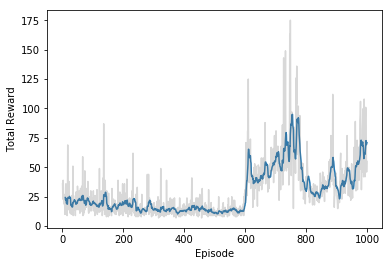

In [18]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

![png](output_21_1.png)


## Playing Atari Games

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.